<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/BreastCancerWins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Wisconsin Dataset

In [47]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time


#Convert and import personalised library
!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilsTFG


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/utilsTFG.ipynb to python
[NbConvertApp] Writing 42112 bytes to /content/drive/MyDrive/Colab Notebooks/utilsTFG.py


In [ ]:
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

### Datos y modelos

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

#Show the data
print(X.head())




# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

df=pd.concat([X, y], axis=1)

# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'Diagnosis'

# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (50% each)
val_test_split = RandomSplitter(valid_pct=0.5)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create TabularPandas for training and validation
to = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create TabularPandas for training and validation to be used in MH
to_mh = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=16, shuffle=True)

dls_mh = to_mh.dataloaders(bs=16, shuffle=True)

test_to = TabularPandas(
    df.iloc[test_idx],  # Select only the test data
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=16, shuffle=False)

   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

In [50]:
#Create array of 1, 2, 5 and 11 hidden layers for MLP
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [51]:
for layer in layers:
  learn = tabular_learner(dls, layers=layer, metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 16 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 30             
BatchNorm1d                               60         True      
____________________________________________________________________________
                     16 x 64             
Linear                                    1920       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     16 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 2,238
Total trainable params: 2,238
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7eaed7296e60>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 16 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 30             
BatchNorm1d                               60         True      
____________________________________________________________________________
                     16 x 64             
Linear                                    1920       True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     16 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 6,462
Total train

TabularModel (Input shape: 16 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 30             
BatchNorm1d                               60         True      
____________________________________________________________________________
                     16 x 64             
Linear                                    1920       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     16 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     16 x 256            
Linear                                    32768      T

TabularModel (Input shape: 16 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 30             
BatchNorm1d                               60         True      
____________________________________________________________________________
                     16 x 32             
Linear                                    960        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     16 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     16 x 128            
Linear                                    8192       T

## Gradient Descent

In [54]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=100

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, metrics=accuracy, opt_func=opt2, cbs=[EarlyStoppingCallback(patience=3), SaveModelCallback()])
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [17]:
def compare_models(model1, model2):
    for param1, param2 in zip(model1.state_dict().items(), model2.state_dict().items()):
        if not torch.equal(param1[1], param2[1]):
            return False
    return True

# Example usage
model1 = learners['NAG'][5].model  # PyTorch model with 1 hidden layer
model2 = learners['RMSProp'][5].model  # PyTorch model with 1 hidden layer

if compare_models(model1, model2):
    print("Mismos parámetros.")
else:
    print("Distintos parámetros.")

Mismos parámetros.


### Nesterov

In [58]:
time_gd

{'NAG': {1: 2.8114839380004923,
  2: 2.6417485629999646,
  5: 6.833252489000188,
  11: 11.33823292299985},
 'RMSProp': {},
 'ADAM': {}}

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.171434,0.091984,0.964706,00:00
1,0.140933,0.085199,0.964706,00:00
2,0.126733,0.077219,0.964706,00:00
3,0.116449,0.057700,0.976471,00:00
4,0.147187,0.067346,0.964706,00:00
5,0.136464,0.060104,0.988235,00:00
6,0.146565,0.064538,0.988235,00:00


Better model found at epoch 0 with valid_loss value: 0.09198424965143204.
Better model found at epoch 1 with valid_loss value: 0.08519948273897171.
Better model found at epoch 2 with valid_loss value: 0.0772186815738678.
Better model found at epoch 3 with valid_loss value: 0.05769971013069153.
No improvement since epoch 3: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.119074,0.041103,1.000000,00:00
1,0.122827,0.050364,1.000000,00:00
2,0.121172,0.039146,1.000000,00:00
3,0.137540,0.045178,1.000000,00:00
4,0.131043,0.051756,0.988235,00:00
5,0.155843,0.062906,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.04110344871878624.
Better model found at epoch 2 with valid_loss value: 0.039146099239587784.
No improvement since epoch 2: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.171159,0.145471,0.929412,00:00
1,0.186346,0.116663,0.952941,00:00
2,0.209609,0.110388,0.976471,00:00
3,0.197925,0.114890,0.952941,00:00
4,0.181440,0.109883,0.964706,00:00
5,0.178785,0.115339,0.964706,00:00
6,0.166984,0.107066,0.976471,00:00
7,0.159148,0.101284,0.964706,00:00
8,0.152210,0.096487,0.964706,00:00
9,0.131827,0.108950,0.964706,00:00


Better model found at epoch 0 with valid_loss value: 0.1454712152481079.
Better model found at epoch 1 with valid_loss value: 0.11666273325681686.
Better model found at epoch 2 with valid_loss value: 0.11038821935653687.
Better model found at epoch 4 with valid_loss value: 0.10988260060548782.
Better model found at epoch 6 with valid_loss value: 0.10706593841314316.
Better model found at epoch 7 with valid_loss value: 0.1012844666838646.
Better model found at epoch 8 with valid_loss value: 0.09648655354976654.
Better model found at epoch 10 with valid_loss value: 0.09234074503183365.
Better model found at epoch 13 with valid_loss value: 0.08116082847118378.
No improvement since epoch 13: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.381341,0.412344,0.823529,00:00
1,0.402792,0.319277,0.894118,00:00
2,0.352499,0.303924,0.870588,00:00
3,0.332039,0.291180,0.894118,00:00
4,0.300475,0.267391,0.894118,00:00
5,0.287989,0.252837,0.894118,00:00
6,0.270318,0.224166,0.929412,00:00
7,0.260085,0.261116,0.917647,00:00
8,0.249875,0.221897,0.941176,00:00
9,0.238243,0.228720,0.929412,00:00


Better model found at epoch 0 with valid_loss value: 0.41234448552131653.
Better model found at epoch 1 with valid_loss value: 0.31927722692489624.
Better model found at epoch 2 with valid_loss value: 0.303923636674881.
Better model found at epoch 3 with valid_loss value: 0.29117998480796814.
Better model found at epoch 4 with valid_loss value: 0.2673906981945038.
Better model found at epoch 5 with valid_loss value: 0.2528367042541504.
Better model found at epoch 6 with valid_loss value: 0.22416619956493378.
Better model found at epoch 8 with valid_loss value: 0.22189737856388092.
Better model found at epoch 10 with valid_loss value: 0.20378559827804565.
Better model found at epoch 11 with valid_loss value: 0.17514458298683167.
No improvement since epoch 11: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

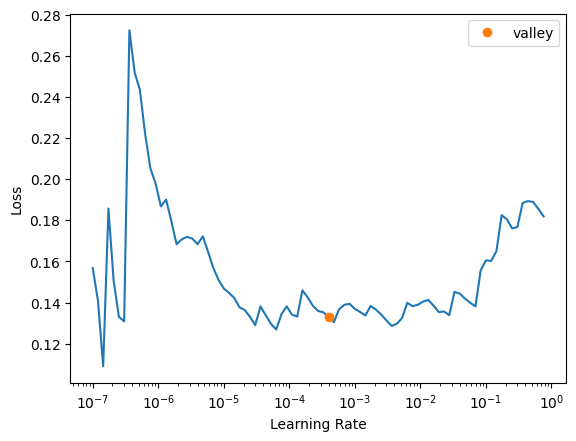

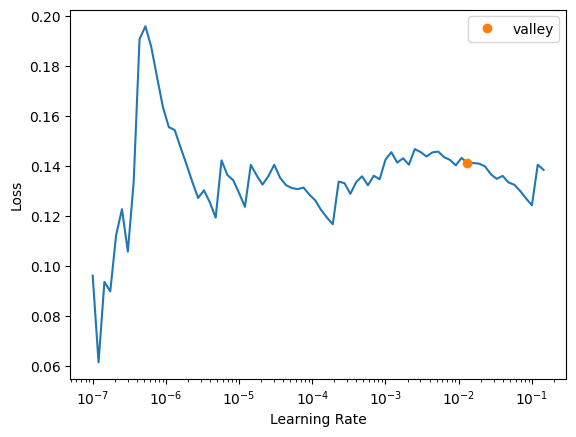

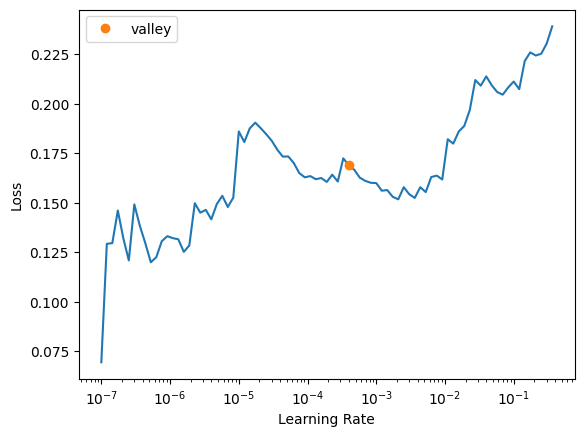

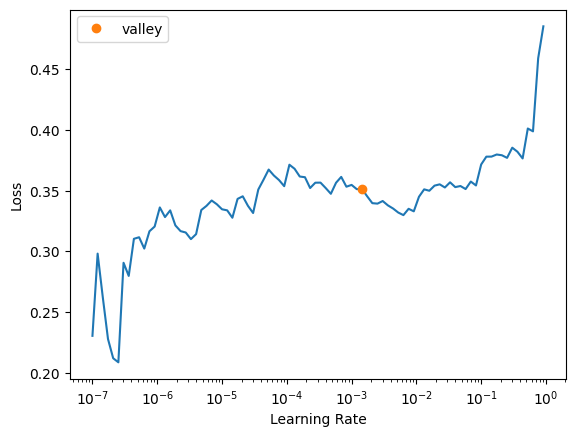

In [57]:
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



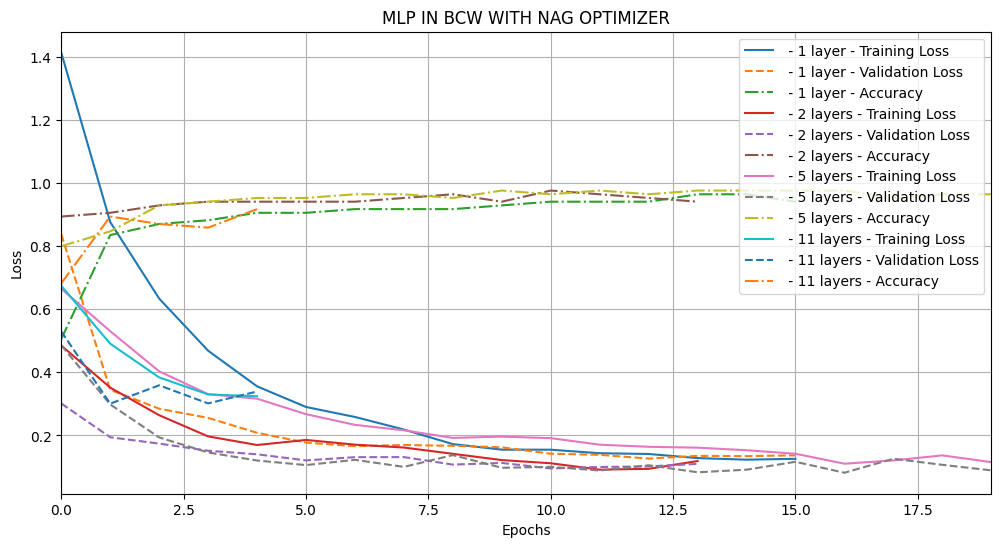

In [19]:
utilsTFG.plot_learners_training(learners['NAG'].values(), title='MLP IN BCW WITH NAG OPTIMIZER', names=names_layer)

### RMSProp

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.467640,0.249576,0.905882,00:00
1,0.312653,0.148244,0.941176,00:00
2,0.252416,0.115551,0.964706,00:00
3,0.194911,0.151388,0.941176,00:00
4,0.188784,0.159753,0.941176,00:00
5,0.170065,0.127166,0.964706,00:00


Better model found at epoch 0 with valid_loss value: 0.2495756447315216.
Better model found at epoch 1 with valid_loss value: 0.14824408292770386.
Better model found at epoch 2 with valid_loss value: 0.11555147916078568.
No improvement since epoch 2: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.251734,0.285458,0.917647,00:00
1,0.189294,0.146124,0.941176,00:00
2,0.169235,0.121819,0.941176,00:00
3,0.142537,0.128204,0.941176,00:00
4,0.129294,0.159274,0.941176,00:00
5,0.114770,0.085714,0.976471,00:00
6,0.115573,0.100859,0.964706,00:00
7,0.095475,0.089915,0.976471,00:00
8,0.101855,0.135774,0.952941,00:00


Better model found at epoch 0 with valid_loss value: 0.2854580283164978.
Better model found at epoch 1 with valid_loss value: 0.14612385630607605.
Better model found at epoch 2 with valid_loss value: 0.12181874364614487.
Better model found at epoch 5 with valid_loss value: 0.08571425080299377.
No improvement since epoch 5: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.301252,0.185036,0.917647,00:00
1,0.217951,0.122408,0.952941,00:00
2,0.180190,0.121235,0.964706,00:00
3,0.170485,0.132401,0.964706,00:00
4,0.161047,0.123498,0.941176,00:00
5,0.155652,0.248298,0.894118,00:00


Better model found at epoch 0 with valid_loss value: 0.1850358098745346.
Better model found at epoch 1 with valid_loss value: 0.12240751087665558.
Better model found at epoch 2 with valid_loss value: 0.12123473733663559.
No improvement since epoch 2: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.504418,0.275175,0.905882,00:00
1,0.404089,0.555324,0.811765,00:00
2,0.351366,0.261667,0.882353,00:00
3,0.305222,0.258402,0.894118,00:00
4,0.251651,0.254562,0.894118,00:00
5,0.221956,0.322599,0.917647,00:00
6,0.186840,0.464259,0.929412,00:00
7,0.217076,0.385301,0.870588,00:00


Better model found at epoch 0 with valid_loss value: 0.2751748859882355.
Better model found at epoch 2 with valid_loss value: 0.26166704297065735.
Better model found at epoch 3 with valid_loss value: 0.2584016025066376.
Better model found at epoch 4 with valid_loss value: 0.25456228852272034.
No improvement since epoch 4: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

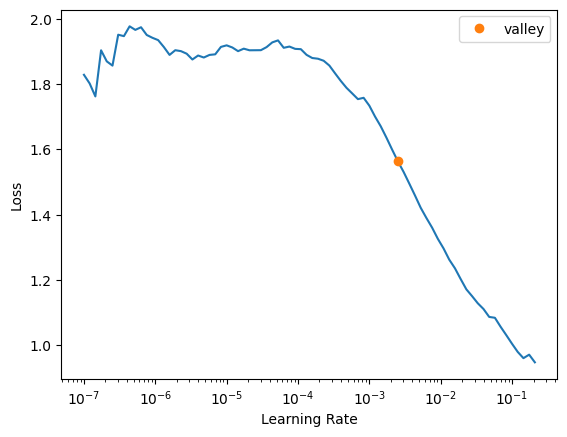

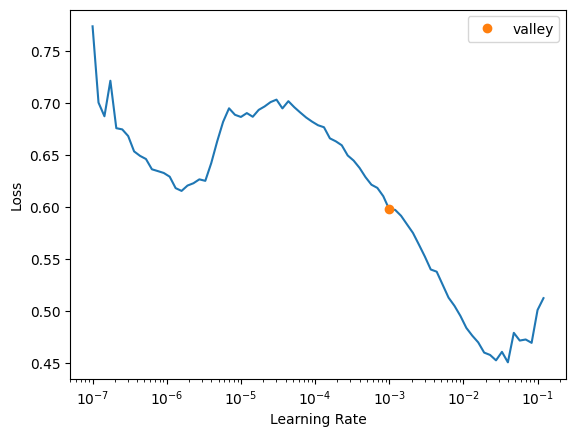

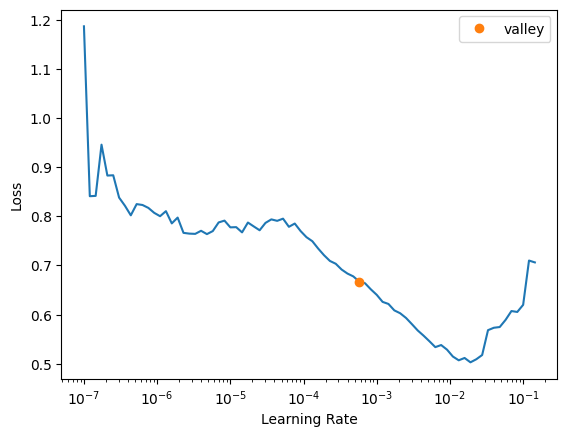

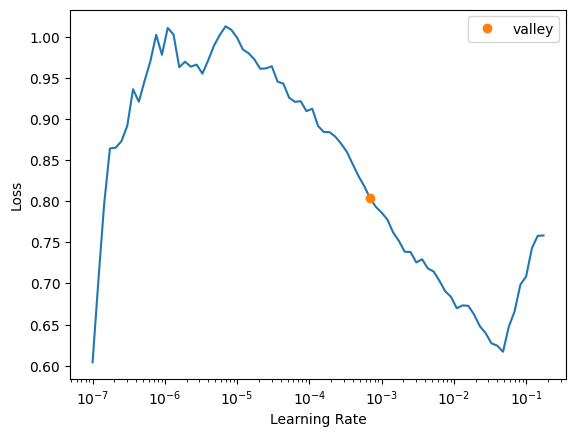

In [20]:
for _, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


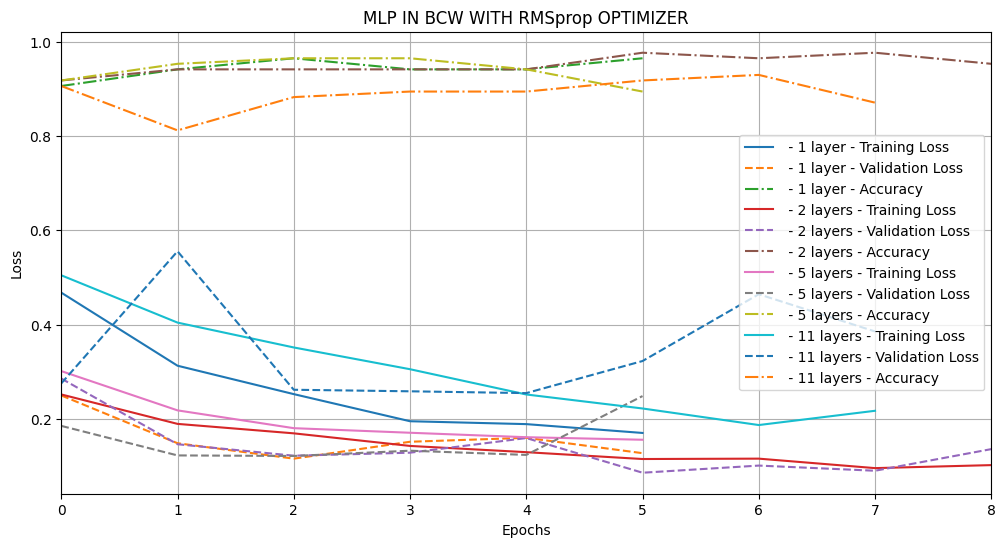

In [21]:
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='MLP IN BCW WITH RMSprop OPTIMIZER', names=names_layer)

### Adam

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,1.686410,1.496944,0.258824,00:00
1,1.482159,1.281946,0.352941,00:00
2,1.286792,0.860630,0.564706,00:00
3,1.047160,0.609693,0.705882,00:00
4,0.825511,0.454855,0.776471,00:00
5,0.648667,0.362291,0.835294,00:00
6,0.507731,0.320202,0.847059,00:00
7,0.434923,0.254249,0.882353,00:00
8,0.363468,0.215744,0.894118,00:00
9,0.318340,0.196967,0.894118,00:00


Better model found at epoch 0 with valid_loss value: 1.4969440698623657.
Better model found at epoch 1 with valid_loss value: 1.2819463014602661.
Better model found at epoch 2 with valid_loss value: 0.8606299757957458.
Better model found at epoch 3 with valid_loss value: 0.609693169593811.
Better model found at epoch 4 with valid_loss value: 0.4548551142215729.
Better model found at epoch 5 with valid_loss value: 0.3622910678386688.
Better model found at epoch 6 with valid_loss value: 0.3202017843723297.
Better model found at epoch 7 with valid_loss value: 0.25424855947494507.
Better model found at epoch 8 with valid_loss value: 0.21574442088603973.
Better model found at epoch 9 with valid_loss value: 0.19696736335754395.
Better model found at epoch 10 with valid_loss value: 0.19260267913341522.
Better model found at epoch 11 with valid_loss value: 0.17614878714084625.
Better model found at epoch 12 with valid_loss value: 0.15993933379650116.
Better model found at epoch 13 with valid_l

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.531753,0.460681,0.776471,00:00
1,0.434094,0.304144,0.905882,00:00
2,0.362900,0.251769,0.905882,00:00
3,0.311568,0.206915,0.917647,00:00
4,0.250302,0.178457,0.941176,00:00
5,0.241469,0.168301,0.929412,00:00
6,0.199258,0.146061,0.952941,00:00
7,0.186826,0.123117,0.964706,00:00
8,0.183240,0.125703,0.941176,00:00
9,0.167254,0.126068,0.952941,00:00


Better model found at epoch 0 with valid_loss value: 0.46068060398101807.
Better model found at epoch 1 with valid_loss value: 0.3041442036628723.
Better model found at epoch 2 with valid_loss value: 0.2517693042755127.
Better model found at epoch 3 with valid_loss value: 0.2069152146577835.
Better model found at epoch 4 with valid_loss value: 0.1784573793411255.
Better model found at epoch 5 with valid_loss value: 0.16830116510391235.
Better model found at epoch 6 with valid_loss value: 0.1460607647895813.
Better model found at epoch 7 with valid_loss value: 0.12311700731515884.
Better model found at epoch 10 with valid_loss value: 0.10306833684444427.
No improvement since epoch 10: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.378566,0.201931,0.929412,00:00
1,0.294556,0.160414,0.941176,00:00
2,0.265700,0.133275,0.952941,00:02
3,0.212313,0.101757,0.964706,00:00
4,0.204921,0.127552,0.952941,00:01
5,0.170430,0.090917,0.964706,00:02
6,0.185876,0.155084,0.941176,00:01
7,0.185250,0.204421,0.905882,00:00
8,0.201855,0.142710,0.964706,00:00


Better model found at epoch 0 with valid_loss value: 0.20193099975585938.
Better model found at epoch 1 with valid_loss value: 0.16041387617588043.
Better model found at epoch 2 with valid_loss value: 0.13327528536319733.
Better model found at epoch 3 with valid_loss value: 0.10175696015357971.
Better model found at epoch 5 with valid_loss value: 0.09091684222221375.
No improvement since epoch 5: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.714033,0.579721,0.694118,00:00
1,0.598779,0.357236,0.858824,00:00
2,0.467271,0.315908,0.847059,00:00
3,0.426795,0.242591,0.858824,00:00
4,0.374802,0.210117,0.917647,00:00
5,0.335683,0.385098,0.823529,00:00
6,0.298316,0.258688,0.929412,00:00
7,0.279500,0.328995,0.882353,00:00


Better model found at epoch 0 with valid_loss value: 0.5797213315963745.
Better model found at epoch 1 with valid_loss value: 0.35723596811294556.
Better model found at epoch 2 with valid_loss value: 0.3159080147743225.
Better model found at epoch 3 with valid_loss value: 0.2425912469625473.
Better model found at epoch 4 with valid_loss value: 0.21011681854724884.
No improvement since epoch 4: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

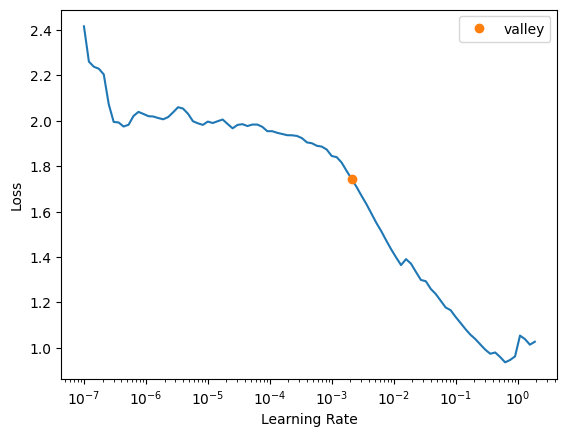

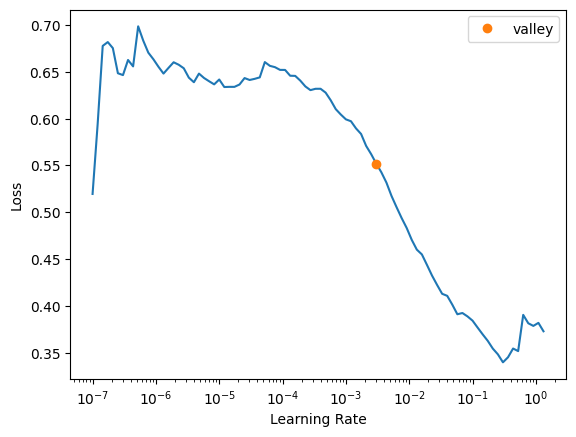

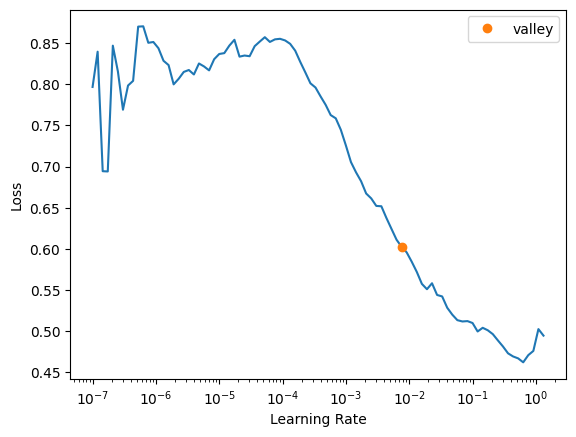

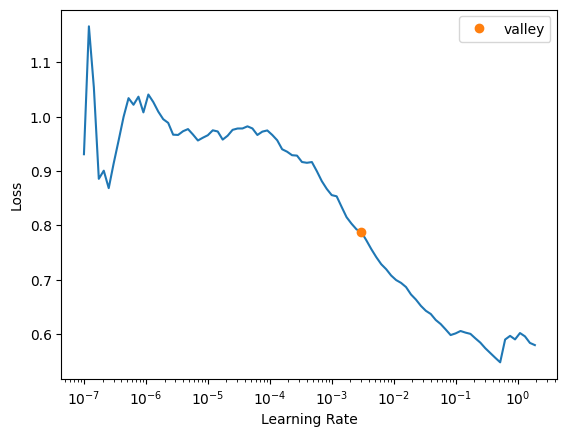

In [22]:
for _, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


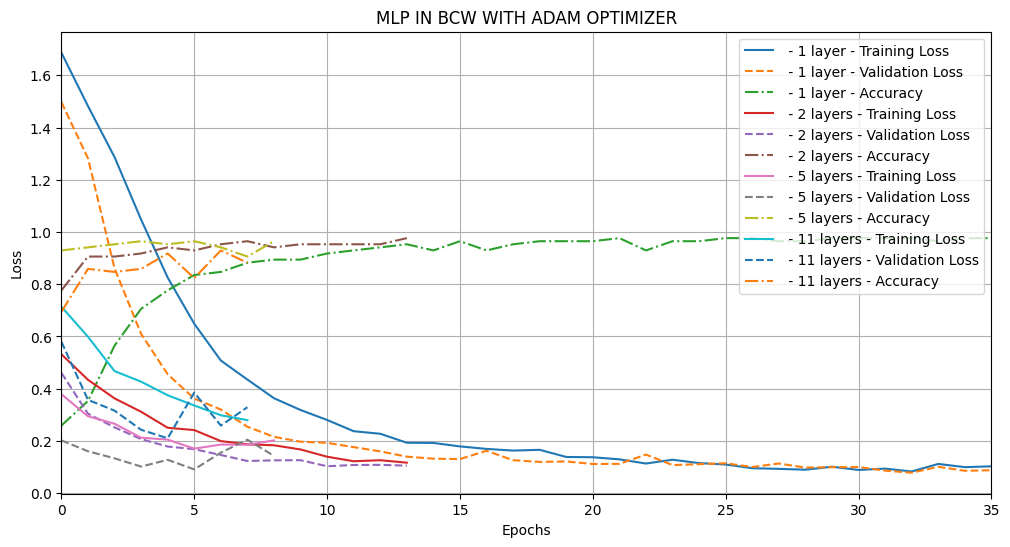

In [23]:
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='MLP IN BCW WITH ADAM OPTIMIZER', names=names_layer)

### Save or Load models

In [24]:
#Save the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(learners, f)

KeyboardInterrupt: 

In [ ]:
#Load the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'rb') as f:
    learners = pickle.load(f)

### Comparative per layers

In [ ]:
#Compare the three optimizers in each layer version

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_15_layers = [learners['NAG'][15], learners['RMSProp'][15], learners['ADAM'][15]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title='MLP IN BCW WITH 1 LAYER', names=names)
utilsTFG.plot_learners_training(learners_2_layers, title='MLP IN BCW WITH 2 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_5_layers, title='MLP IN BCW WITH 5 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_15_layers, title='MLP IN BCW WITH 10 LAYERS', names=names)

### Generalization

In [ ]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate accuracy
    correct = (preds.argmax(dim=1) == targs).sum()
    total = targs.size(0)
    accuracy = correct / total

    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Accuracy: {accuracy.item()}")

## Metaheuristics

In [4]:
#layer=[16,32,64, 64,32,16]
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, cbs=[SaveModelCallback()])
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}


In [5]:
max_evals=100
max_evals_shade=50
max_ls=10

### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
results['GA'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
  end = time.perf_counter()
  time_mh['GA'][layer] = end-start

KeyboardInterrupt: 

### SHADE

In [7]:
#SHADE alg not working completely wrong

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,100, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [9]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [41]:
#compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  #Compare test

  print("\n")

Training error of SHADE for 1 layers: [0.678844153881073, 0.678844153881073, 0.5751025080680847, 0.5503968596458435, 0.47671791911125183, 0.4591318368911743, 0.3935253322124481, 0.32814645767211914, 0.32814645767211914, 0.32814645767211914, 0.32814645767211914]
Validation error of SHADE for 1 layers: [0.24081836640834808, 0.24081836640834808, 0.24081836640834808, 0.39248475432395935, 0.21274709701538086, 0.21274709701538086, 0.2651349604129791, 0.21274709701538086, 0.21274709701538086, 0.21274709701538086, 0.21274709701538086]
Difference: [-0.43802579 -0.43802579 -0.33428414 -0.15791211 -0.26397082 -0.24638474
 -0.12839037 -0.11539936 -0.11539936 -0.11539936 -0.11539936]
Best generalizing model: Model 5 (1-10)


Training error of SHADE for 2 layers: [0.6332207322120667, 0.6332207322120667, 0.5669724345207214, 0.5669724345207214, 0.5669724345207214, 0.5318917632102966, 0.5318917632102966, 0.45532146096229553, 0.45532146096229553, 0.4537096321582794, 0.4537096321582794]
Validation error 

### SHADE-ILS

In [12]:
# Working fine
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.7869842608490651, 0.0], maxlen=3)
deque([0.7869842608490651, 0.0, 0.02249026534063502], maxlen=3)
84
eo
deque([0.0, 0.02249026534063502, 0.0671690425208033], maxlen=3)
deque([0.02249026534063502, 0.0671690425208033, -0.1236566157299719], maxlen=3)
146
eo
deque([1, 0.664721225157269, 0.03225488344370647], maxlen=3)
deque([0.664721225157269, 0.03225488344370647, 0.141301455429621], maxlen=3)
72
eo
deque([0.03225488344370647, 0.141301455429621, 0.0], maxlen=3)
deque([0.141301455429621, 0.0, 0.03821700056850829], maxlen=3)
134
eo
deque([1, 0.669012094553513, 0.0], maxlen=3)
deque([0.669012094553513, 0.0, -0.15727161684269667], maxlen=3)
73
eo
deque([0.0, -0.15727161684269667, 0.0], maxlen=3)
deque([-0.15727161684269667, 0.0, -0.17076084187184487], maxlen=3)
Reiniciado
141
eo
deque([1, 0.6914032479322971, 0.0], maxlen=3)
deque([0.6914032479322971, 0.0, -0.01709233742063523], maxlen=3)
80
eo
deque([0.0, -0.01709233742063523, 0.0], maxlen=3)
deque([-0.01709233742063523, 0.0, -0

In [13]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [40]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [0.678844153881073, 0.14460448920726776, 0.14135229587554932, 0.14135229587554932]
Validation error of SHADE-ILS for 1 layers: [0.6950824856758118, 0.06266333162784576, 0.07170993834733963, 0.07170993834733963]
Difference: [ 0.01623833 -0.08194116 -0.06964236 -0.06964236]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS for 2 layers: [0.6332207322120667, 0.2123054713010788, 0.17642612755298615, 0.16968365013599396]
Validation error of SHADE-ILS for 2 layers: [0.6937107443809509, 0.08285290747880936, 0.054444897919893265, 0.06194278225302696]
Difference: [ 0.06049001 -0.12945256 -0.12198123 -0.10774087]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-ILS for 5 layers: [0.6077039837837219, 0.20114266872406006, 0.20114266872406006, 0.20114266872406006]
Validation error of SHADE-ILS for 5 layers: [0.8873298764228821, 0.7396283149719238, 0.7396283149719238, 0.7396283149719238]
Difference: [0.27962589 0.53848565

### SHADE-GD

In [15]:
# Working ???
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


eo
deque([1, 0.8297514885923972, 0.0], maxlen=3)
deque([0.8297514885923972, 0.0, -0.16151398941157138], maxlen=3)
76
eo
deque([0.0, -0.16151398941157138, 0.015309133740847228], maxlen=3)
deque([-0.16151398941157138, 0.015309133740847228, -0.11890759404984615], maxlen=3)
Reiniciado
148
eo
deque([1, 0.6948143491883839, 0.016862650149050258], maxlen=3)
deque([0.6948143491883839, 0.016862650149050258, 0.09525727343771323], maxlen=3)
67
eo
deque([0.016862650149050258, 0.09525727343771323, 0.004643470495085932], maxlen=3)
deque([0.09525727343771323, 0.004643470495085932, -0.27471932560807416], maxlen=3)
130
eo
deque([1, 0.6257734600902096, 0.0], maxlen=3)
deque([0.6257734600902096, 0.0, 0.24099190477051635], maxlen=3)
74
eo
deque([0.0, 0.24099190477051635, 0.0], maxlen=3)
deque([0.24099190477051635, 0.0, -0.3419912773394616], maxlen=3)
132
eo
deque([1, 0.5979135765125677, 0.0], maxlen=3)
deque([0.5979135765125677, 0.0, 0.02852020358333915], maxlen=3)
67
eo
deque([0.0, 0.02852020358333915, 0.

In [16]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [42]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [0.678844153881073, 0.11557220667600632, 0.11557220667600632, 0.11557220667600632]
Validation error of SHADE-GD for 1 layers: [1.0389161109924316, 0.43063077330589294, 0.43063077330589294, 0.43063077330589294]
Difference: [ 0.01623833 -0.05290888 -0.04386227 -0.04386227]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-GD for 2 layers: [0.6332207322120667, 0.1932498812675476, 0.1718931347131729, 0.1718931347131729]
Validation error of SHADE-GD for 2 layers: [0.6839403510093689, 0.08159589022397995, 0.0803917720913887, 0.0803917720913887]
Difference: [ 0.06049001 -0.11039697 -0.11744824 -0.10995035]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-GD for 5 layers: [0.6077039837837219, 0.2274189591407776, 0.17261283099651337, 0.17261283099651337]
Validation error of SHADE-GD for 5 layers: [0.8712310194969177, 0.14511066675186157, 0.11361601948738098, 0.11361601948738098]
Difference: [0.27962589 0.51220936 0.567015

### SHADE-ILS-GD

In [18]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


eo
deque([1, 0.8297514885923972, 0.0], maxlen=3)
deque([0.8297514885923972, 0.0, -0.16151398941157138], maxlen=3)
76
eo
deque([0.0, -0.16151398941157138, 0.015309133740847228], maxlen=3)
deque([-0.16151398941157138, 0.015309133740847228, -0.11890759404984615], maxlen=3)
Reiniciado
148
eo
deque([1, 0.5965048743462835, 0.07887101057982153], maxlen=3)
deque([0.5965048743462835, 0.07887101057982153, 0.27425217292147636], maxlen=3)
78
eo
deque([0.07887101057982153, 0.27425217292147636, 0.0], maxlen=3)
deque([0.27425217292147636, 0.0, 0.30345101733443236], maxlen=3)
137
eo
deque([1, 0.7388963169435857, 0.0], maxlen=3)
deque([0.7388963169435857, 0.0, -0.13071616761743415], maxlen=3)
77
eo
deque([0.0, -0.13071616761743415, 0.0], maxlen=3)
deque([-0.13071616761743415, 0.0, -0.23053096114020083], maxlen=3)
Reiniciado
145
eo
deque([1, 0.6914032479322971, 0.0], maxlen=3)
deque([0.6914032479322971, 0.0, -0.01709233742063523], maxlen=3)
80
eo
deque([0.0, -0.01709233742063523, 0.0], maxlen=3)
deque([

In [19]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [43]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [0.678844153881073, 0.11557220667600632, 0.11557220667600632, 0.11557220667600632]
Validation error of SHADE-ILS-GD for 1 layers: [1.048301339149475, 0.4349069595336914, 0.4349069595336914, 0.4349069595336914]
Difference: [0.36945719 0.31933475 0.31933475 0.31933475]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS-GD for 2 layers: [0.6332207322120667, 0.25550147891044617, 0.17080461978912354, 0.11897378414869308]
Validation error of SHADE-ILS-GD for 2 layers: [1.0168349742889404, 0.07407626509666443, 0.07834941893815994, 0.08298467099666595]
Difference: [ 0.38361424 -0.18142521 -0.0924552  -0.03598911]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS-GD for 5 layers: [0.6077039837837219, 0.1586737483739853, 0.1586737483739853, 0.1586737483739853]
Validation error of SHADE-ILS-GD for 5 layers: [0.8865523338317871, 0.7502698302268982, 0.7502698302268982, 0.7502698302268982]
Difference: [0.27884835 0.5

### Comparison between MH

In [21]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [31]:
#Calculate accuracy
accuracy = {}
for mh in algs:
  accuracy[mh] = {}
  for layer in n_layers:
    accuracy[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.train)
      targs = targs.long().squeeze()

      # Calculate accuracy
      correct = (preds.argmax(dim=1) == targs).sum()
      total = targs.size(0)
      acc = correct / total
      accuracy[mh][layer].append(acc.item())

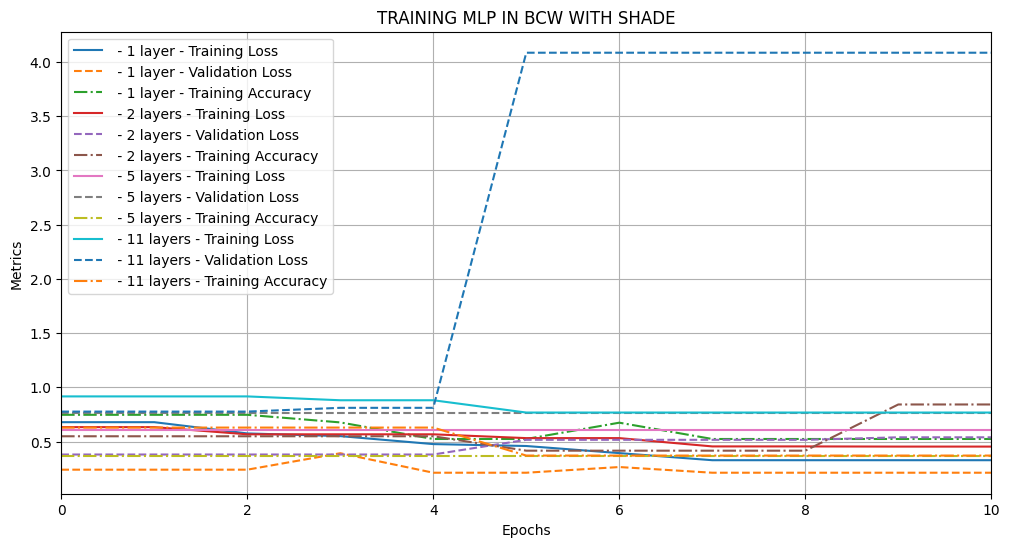

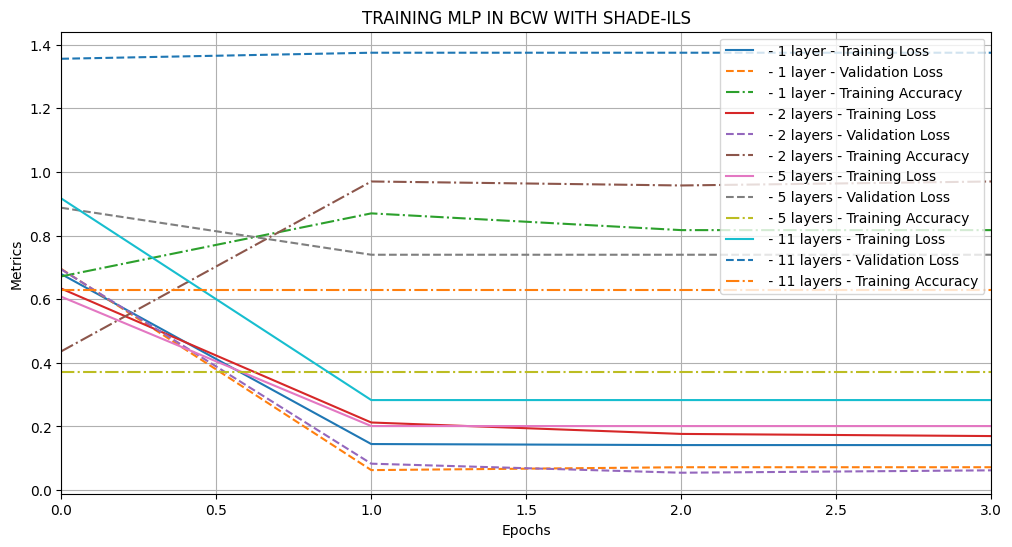

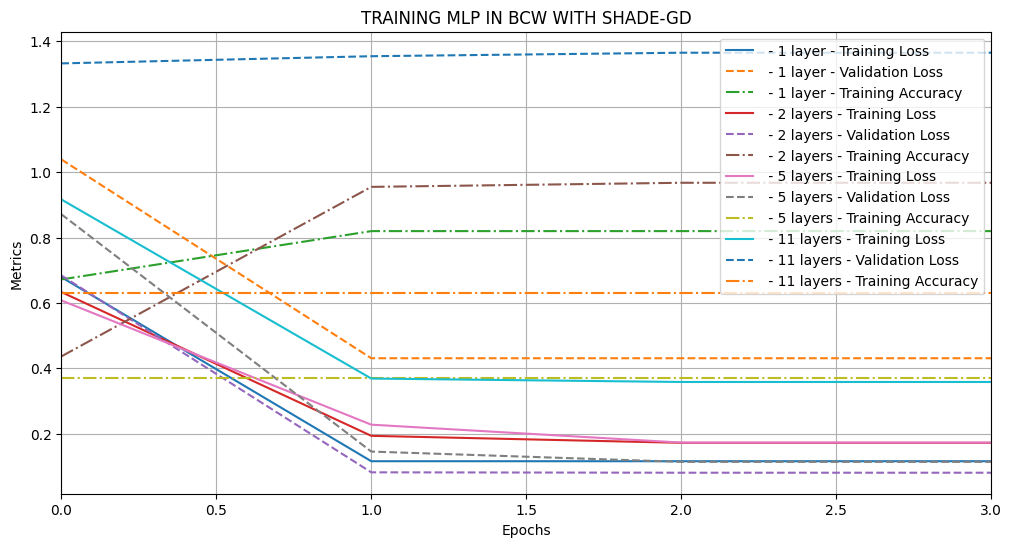

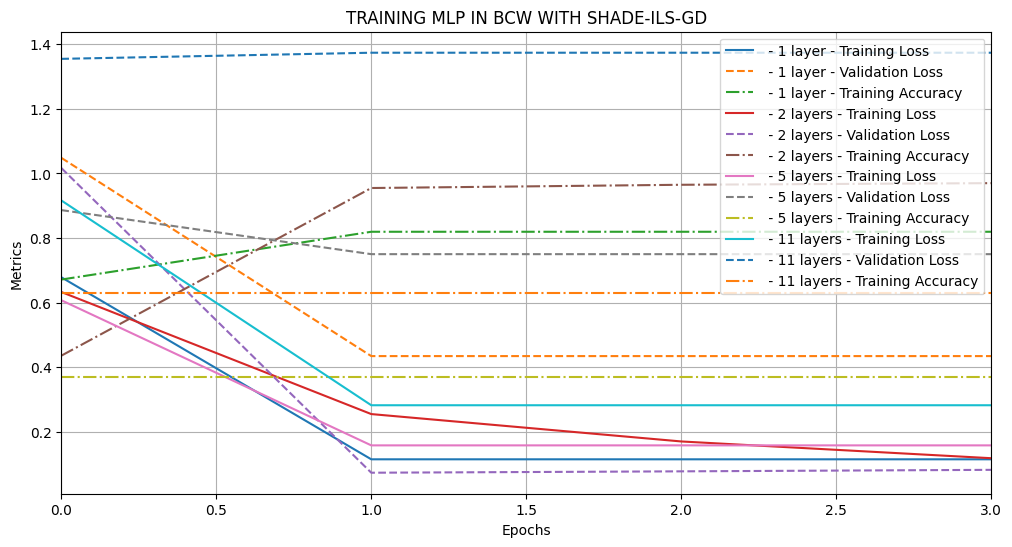

In [44]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], accuracy[alg], layers = n_layers, names=names, title=f'TRAINING MLP IN BCW WITH {alg}')

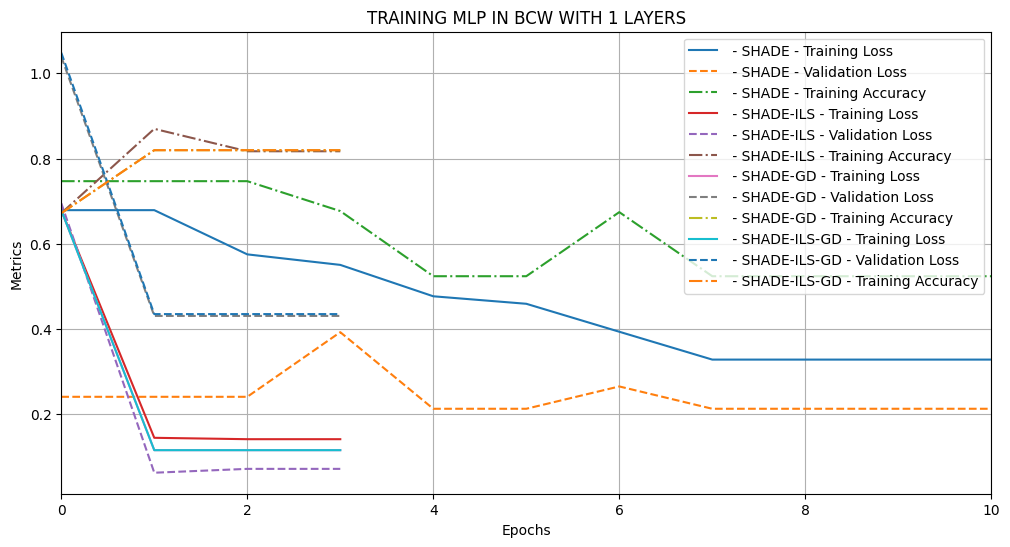

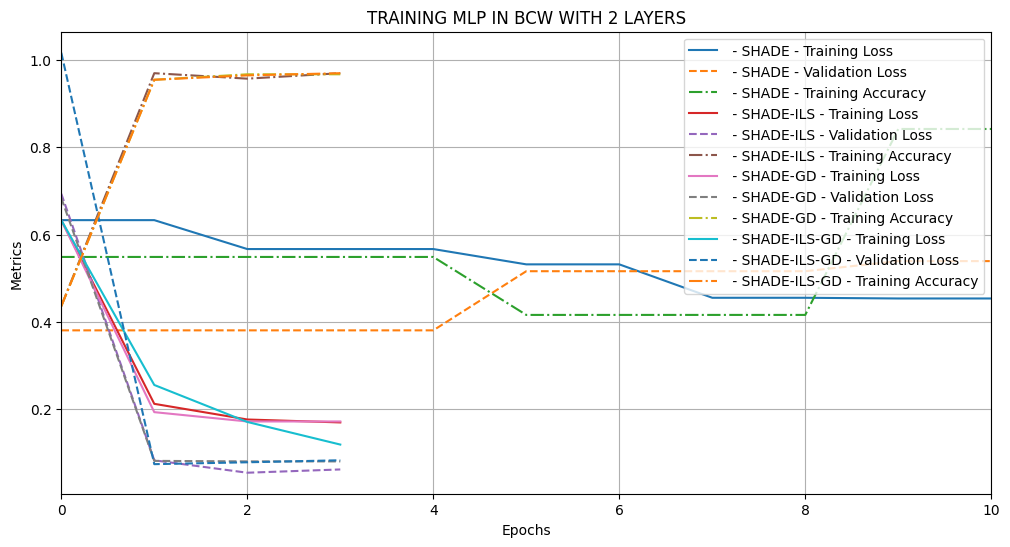

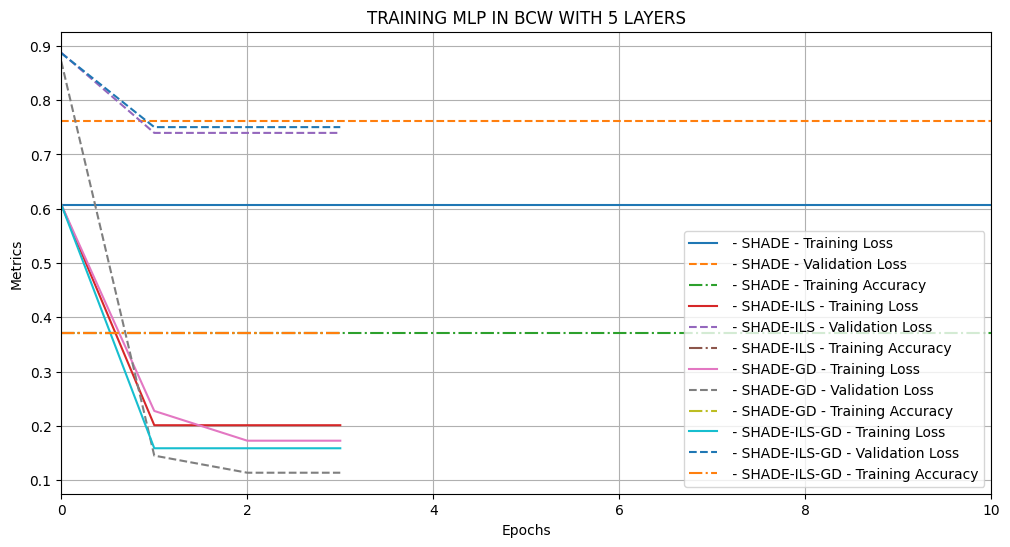

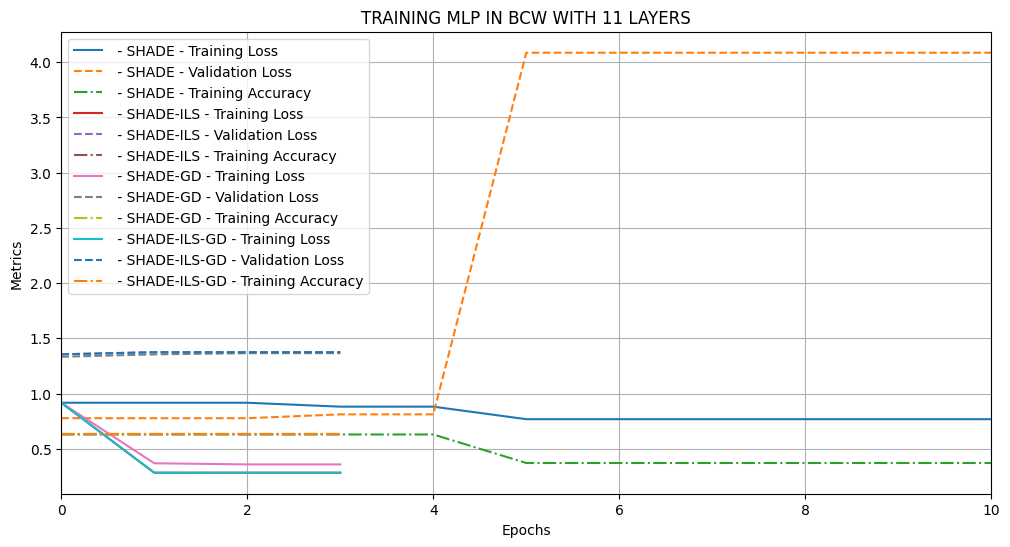

In [45]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = accuracy[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], layers = names, names=names, title=f'TRAINING MLP IN BCW WITH {layer} LAYERS')

### Generalization

In [46]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate accuracy
    correct = (preds.argmax(dim=1) == targs).sum()
    total = targs.size(0)
    ac = correct / total

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Accuracy: {ac.item()}")

Optimizer: SHADE, Layers: 1, Loss: 0.6456825733184814, Accuracy: 0.6941176652908325


Optimizer: SHADE, Layers: 2, Loss: 0.7558310031890869, Accuracy: 0.5058823823928833


Optimizer: SHADE, Layers: 5, Loss: 0.8476945757865906, Accuracy: 0.5411764979362488


Optimizer: SHADE, Layers: 11, Loss: 1.716996192932129, Accuracy: 0.4588235318660736


Optimizer: SHADE-ILS, Layers: 1, Loss: 0.5820618271827698, Accuracy: 0.6941176652908325


Optimizer: SHADE-ILS, Layers: 2, Loss: 0.22984997928142548, Accuracy: 0.8941176533699036


Optimizer: SHADE-ILS, Layers: 5, Loss: 0.721228301525116, Accuracy: 0.5411764979362488


Optimizer: SHADE-ILS, Layers: 11, Loss: 1.435653567314148, Accuracy: 0.4588235318660736


Optimizer: SHADE-GD, Layers: 1, Loss: 0.8695691227912903, Accuracy: 0.6000000238418579


Optimizer: SHADE-GD, Layers: 2, Loss: 0.21815979480743408, Accuracy: 0.8941176533699036


Optimizer: SHADE-GD, Layers: 5, Loss: 0.7050526738166809, Accuracy: 0.5411764979362488


Optimizer: SHADE-GD, Layers: 11, Loss: 1.435653567314148, Accuracy: 0.4588235318660736


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 0.8695691227912903, Accuracy: 0.6000000238418579


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 0.30201050639152527, Accuracy: 0.8588235378265381


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 0.7299954891204834, Accuracy: 0.5411764979362488


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 1.435653567314148, Accuracy: 0.4588235318660736


## Time comparison

TypeError: 'dict_items' object is not subscriptable

In [ ]:
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

